# Disaster Tweets Classification

Grant Novota

This notebook walks through the process of classifying disaster-related Tweets using various Natural Language Processing (NLP) and machine learning techniques.

---

## 1. Brief Description of the Problem and Data

### 1.1 Problem Overview

In crisis or disaster situations, individuals often post urgent information on Twitter in real-time. However, tweets can be ambiguous — some may mention a disaster metaphorically (e.g., “My phone is **ablaze** with notifications!”), while others report actual incidents. Our goal is to train a machine learning model that can distinguish between _actual_ disaster tweets and _non-disaster_ tweets.

### 1.2 Dataset Details

The dataset contains around 10,000 labeled tweets with the following columns:

- **id**: Unique identifier for each tweet.
- **keyword**: A keyword from the tweet (where applicable).
- **location**: The user-specified location (may be blank or missing).
- **text**: The tweet text.
- **target**: Binary label indicating whether the tweet is about a real disaster (`1`) or not (`0`).

## 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In this section, we inspect the data to understand its shape, observe missing values, and perform preliminary visualizations. This helps guide our cleaning and modeling strategies.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# This loop checks for available input files in the Kaggle environment or local environment.
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Load train and test datasets
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

### 2.1 Initial Look at the Data

In [5]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


### 2.2 Distribution of Target Variable

This shows how many tweets are labeled `1` (disaster) versus `0` (non-disaster).

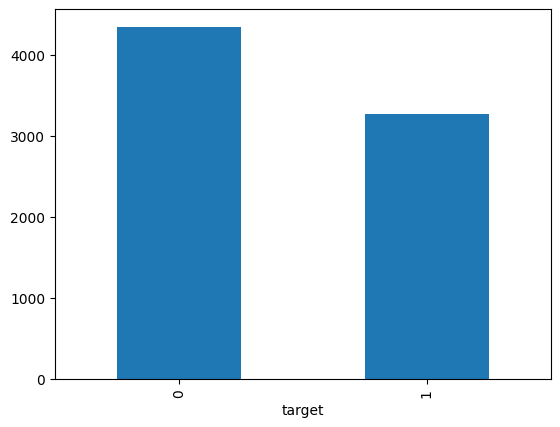

In [8]:
df['target'].value_counts().plot.bar();


### 2.3 Checking Missing Values

In [ ]:
# Percentage of missing values (train set)
print((df.isnull().sum() / len(df)) * 100)

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64


In [ ]:
# Percentage of missing values for target=0
print((df[df['target'] == 0].isnull().sum() / len(df[df['target'] == 0])) * 100)

id           0.000000
keyword      0.437586
location    33.578996
text         0.000000
target       0.000000
dtype: float64


In [ ]:
# Percentage of missing values for target=1
print((df[df['target'] == 1].isnull().sum() / len(df[df['target'] == 1])) * 100)

id           0.000000
keyword      1.284011
location    32.864567
text         0.000000
target       0.000000
dtype: float64


#### Visualizing Missing Values by Target Class

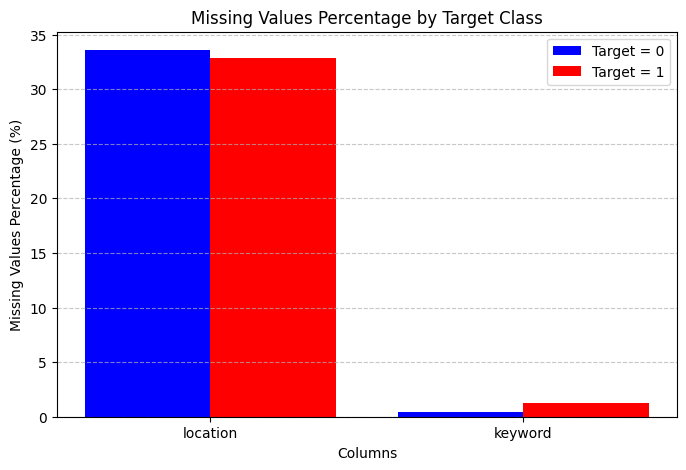

In [ ]:
# Calculate missing values percentage for target = 0
missing_target_0 = (df[df['target'] == 0].isnull().sum() / len(df[df['target'] == 0])) * 100
location_missing_0 = missing_target_0['location']
keyword_missing_0 = missing_target_0['keyword']

# Calculate missing values percentage for target = 1
missing_target_1 = (df[df['target'] == 1].isnull().sum() / len(df[df['target'] == 1])) * 100
location_missing_1 = missing_target_1['location']
keyword_missing_1 = missing_target_1['keyword']

missing_values = {
    "location": [location_missing_0, location_missing_1],
    "keyword": [keyword_missing_0, keyword_missing_1]
}

# X-axis labels
categories = list(missing_values.keys())

# Values for each target class
target_0 = [missing_values[col][0] for col in categories]
target_1 = [missing_values[col][1] for col in categories]

bar_width = 0.4
x = np.arange(len(categories))

# Plot bars
plt.figure(figsize=(8, 5))
plt.bar(x - bar_width / 2, target_0, bar_width, color='blue', label="Target = 0")
plt.bar(x + bar_width / 2, target_1, bar_width, color='red', label="Target = 1")

# Labels and title
plt.xlabel("Columns")
plt.ylabel("Missing Values Percentage (%)")
plt.title("Missing Values Percentage by Target Class")
plt.xticks(x, categories)  # Set x-axis labels
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


### 2.4 Unique Keywords and Locations

In [13]:
print("Length", len(df['keyword'].unique()))
df['keyword'].unique()

Length 222


array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [14]:
print(df['location'].unique())
len(df['location'].unique())

[nan 'Birmingham' 'Est. September 2012 - Bristol' ... 'Vancouver, Canada'
 'London ' 'Lincoln']


3342

### 2.5 Dropping/Imputing Unnecessary or Missing Data

We’ll drop the `id` and `location` columns from the training set. For the test set, we’ll also drop `location`. Missing `keyword` entries get filled with an empty string.

In [15]:
df.drop(columns=['id', 'location'], inplace=True, axis=1)
df_test.drop(columns=['location'], inplace=True)

In [16]:
df.dropna(inplace=True)
df_test.fillna({"keyword": ""}, inplace=True)

In [17]:
print("Null values check:")
print(df.isna().sum())

print("--------------------------")

print("rows and columns:")
print(df.shape)

print("---------------------------")
print("---------------------------")
print("---------------------------")


print("Null values check:")
print(df.isna().sum())

print("--------------------------")

print("rows and columns:")
print(df.shape)



Null values check:
keyword    0
text       0
target     0
dtype: int64
--------------------------
rows and columns:
(7552, 3)
---------------------------
---------------------------
---------------------------
Null values check:
keyword    0
text       0
target     0
dtype: int64
--------------------------
rows and columns:
(7552, 3)


In [18]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7552 entries, 31 to 7582
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   keyword  7552 non-null   object
 1   text     7552 non-null   object
 2   target   7552 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 236.0+ KB


## 3. Model Architecture

### 3.1 NLP Preprocessing

To convert text into numerical form, we use **TF-IDF** (Term Frequency–Inverse Document Frequency) after cleaning, tokenizing, and removing stopwords.

**Steps**:
1. **Remove URLs, punctuation, etc.**
2. **Lowercase and tokenize**.
3. **Remove stopwords**.
4. **Stem words** to reduce them to a root form.

In [ ]:
def remove_stop_words(sentence):
    # get stop words
    stop_words = set(stopwords.words('english'))
    stemmer = nltk.PorterStemmer()

    # Remove URLs
    sentence = re.sub(r'https?://\S+|www\.\S+', '', sentence)
    # Remove punctuation/special characters
    sentence = re.sub(r'[^\w\s]', '', sentence)

    # Tokenize sentence and remove stop words
    words = sentence.lower().split()
    filtered_words = [stemmer.stem(word) for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [20]:
print("Before:")
print(df['text'].iloc[4])

print("After:")
print(remove_stop_words(df['text'].iloc[4]))

Before:
On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N
After:
plu side look sky last night ablaz


Apply text cleaning to the entire training and test sets.

In [21]:
df['text'] = df['text'].apply(remove_stop_words)
df_test['text'] = df_test['text'].apply(remove_stop_words)

In [ ]:
print("length before stemm : ", len(df['keyword'].unique()))

length before stemm :  221


### 3.2 Keyword Stemming

In [23]:
def stemming(sentence):
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in sentence.replace("%20", " ").split()])

In [24]:
print("length After stemm : ", len(df['keyword'].unique()))
print("-------------------------------")
df['keyword'].unique()

length After stemm :  221
-------------------------------


array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'derailed

In [25]:
df['keyword'] = df['keyword'].apply(stemming)
df_test['keyword'] = df_test['keyword'].apply(stemming)

In [26]:
print(len(df['keyword'].unique()))
print("-------------------------------")
df['keyword'].unique()

166
-------------------------------


array(['ablaz', 'accid', 'aftershock', 'airplan accid', 'ambul',
       'annihil', 'apocalyps', 'armageddon', 'armi', 'arson', 'arsonist',
       'attack', 'avalanch', 'battl', 'bioterror', 'blaze', 'bleed',
       'blew up', 'blight', 'blizzard', 'blood', 'bloodi', 'blown up',
       'bodi bag', 'bomb', 'bridg collaps', 'build burn', 'build on fire',
       'burn', 'burn build', 'bush fire', 'casualti', 'catastroph',
       'chemic emerg', 'cliff fall', 'collaps', 'collid', 'collis',
       'crash', 'crush', 'curfew', 'cyclon', 'damag', 'danger', 'dead',
       'death', 'debri', 'delug', 'demolish', 'demolit', 'derail',
       'desol', 'destroy', 'destruct', 'deton', 'devast', 'disast',
       'displac', 'drought', 'drown', 'dust storm', 'earthquak',
       'electrocut', 'emerg', 'emerg plan', 'emerg servic', 'engulf',
       'epicentr', 'evacu', 'explod', 'explos', 'eyewit', 'famin',
       'fatal', 'fear', 'fire', 'fire truck', 'first respond', 'flame',
       'flatten', 'flood', 'f

### 3.3 TF-IDF Vectorization

We'll vectorize both the `text` column and `keyword` column, then combine the resulting vectors.

In [27]:
vectorizer = TfidfVectorizer()
X_tweet = vectorizer.fit_transform(df['text'])
X_test_tweet = vectorizer.transform(df_test['text'])

X_keyword = vectorizer.fit_transform(df['keyword'])
X_test_keyword = vectorizer.transform(df_test['keyword'])

In [28]:
X = hstack([X_tweet, X_keyword]) # All training data
X_final_test = hstack([X_test_tweet, X_test_keyword]) # All test data

y = df['target']

### 3.4 Train/Test Split

We'll split the data into training and validation sets for model evaluation.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.5 Model Selection

We'll test multiple models as baselines:
1. **SVM (Support Vector Machine)**
2. **XGBoost**
3. **Random Forest**
4. **Logistic Regression**

In [30]:
models = {
    "SVM": SVC(kernel='linear', C=1.0),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

## 4. Results and Analysis

We train each model, evaluate on the validation set, and compare accuracies.


In [31]:
accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

SVM Accuracy: 0.8101
XGBoost Accuracy: 0.7756
Random Forest Accuracy: 0.7915
Logistic Regression Accuracy: 0.7922


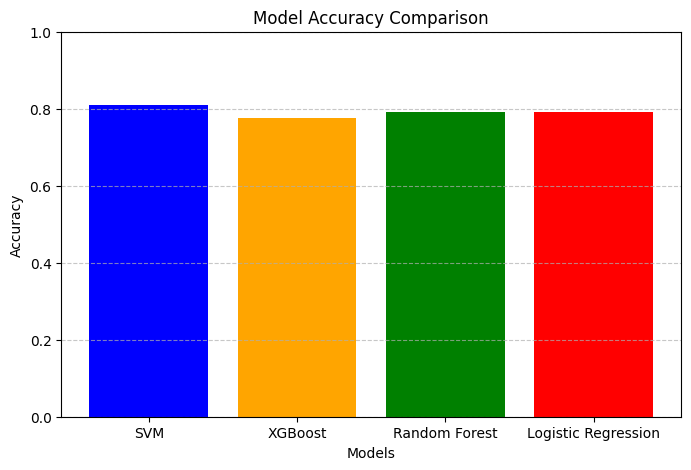

In [32]:
# Plot results
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 4.1 Analysis of What Worked/Didn’t Work

- **SVM** often performs well on text data, especially with TF-IDF features.
- **XGBoost**, **Random Forest**, and **Logistic Regression** can also be viable. Further hyperparameter tuning could improve these results.
- Data preprocessing (stopwords removal, stemming) helps reduce noise.

## 5. Conclusion

**Key Takeaways**:
- **Text cleaning** and **TF-IDF** are strong baselines for NLP tasks.
- **SVM** can yield competitive results with relatively little tuning.
- **Other models** may match or exceed SVM given careful hyperparameter optimization.
- **Future Improvements**:
  - Use advanced embeddings (e.g., GloVe, Word2Vec, BERT).
  - Explore hyperparameter tuning (grid search, random search, or Bayesian optimization).
  - Feature engineering, e.g., adding sentiment, punctuation counts, etc.

---
## 6. Generating Final Predictions

We’ll retrain the best model on **all** training data and predict on the test set.

In [33]:
final_model = SVC(kernel='linear', C=1.0)
final_model.fit(X, y)
df_test['target'] = final_model.predict(X_final_test)

In [34]:
df_test[['id', 'target']].to_csv('submission.csv', index=False)

## 7. References

1. **Kaggle Competition**: [Disaster Tweets NLP Getting Started](https://www.kaggle.com/c/nlp-getting-started/overview)
2. **NLTK Documentation**: [https://www.nltk.org/](https://www.nltk.org/)
3. **TF-IDF Explanation**: [Scikit-learn TF-IDF Vectorizer Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
4. **XGBoost Documentation**: [https://xgboost.readthedocs.io/](https://xgboost.readthedocs.io/)
5. Kaggle Tutorials and Discussion Boards for text classification and starter notebooks.